** This is the Urban Computing homework for MCMC Class **

** By student: Le Xu ** lx565

In [1]:
import pandas as pd
import os
import scipy.optimize as op
import pylab as pl
from pandas.tools.plotting import scatter_matrix
import statsmodels.formula.api as smf
import emcee
import corner
import numpy as np
from scipy.cluster.vq import whiten
import geopandas as gp

pd.options.mode.chained_assignment = None
np.random.seed(6)
%pylab inline

#pl.rcParams['figure.figsize']= (10,10)

Populating the interactive namespace from numpy and matplotlib


# Motivation 
** model the energy consumption from record data. Estimate the robustness of your model and your model uncertanities in an MCMC environment. Use the modules *emcee* to implement MCMC and *corner* to visualize it **


# Obtain the Datasets

### 1. Data on Energy consumption for NYC
https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  

### 2. Data on building information from PLUTO dataset.
http://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v1.zip

* Download Energy Data:

In [ ]:
# !curl -O https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv

* Download Pluto Data:

In [ ]:
# !curl -O http://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v1.zip
#os.system("unzip mn_mappluto_16v1.zip")

* Load the data into dataframe

In [2]:
nrg = gp.GeoDataFrame.from_csv("rows.csv")

bsize = gp.GeoDataFrame.from_file("MNMapPLUTO.shp")

## checking the content of the datasets

In [3]:
nrg.columns

Index([u'NYC Borough, Block, and Lot (BBL)', u'Co-reported BBL Status',
       u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Zip Code',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings'],
      dtype='object')

In [4]:
bsize.columns

Index([    u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
              u'BBL',   u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea',   u'ResidF

clean up columns I am not using

In [5]:
nrg.drop(['Co-reported BBL Status',
       'BBLs Co-reported',
       'Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number',
       'Street Name', 'Borough', 'Zip Code',
       'DOF Benchmarking Submission Status', 
       'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Primary Property Type - Self Selected', 'DOF Number of Buildings'], axis=1, inplace=True)

In [6]:
bsize.drop(['APPBBL', 'APPDate', 'Address', 'AllZoning1', 'AllZoning2',
       'AreaSource', 'AssessLand', 'AssessTot', 'BldgClass',
       'BldgDepth', 'BldgFront', 'Block', 'BoroCode', 'Borough', 'BsmtCode',
       'BuiltCode', 'BuiltFAR', 'CB2010', 'CD', 'CT2010', 'ComArea', 'CommFAR',
       'CondoNo', 'Council', 'EDesigNum', 'Easements', 'ExemptLand',
       'ExemptTot', 'Ext', 'FacilFAR', 'FactryArea', 'FireComp',
       'HealthArea', 'HistDist', 'IrrLotCode', 'LandUse', 'Landmark', 'Lot',
       'LotArea', 'LotDepth', 'LotFront', 'LotType', 'LtdHeight', 'MAPPLUTO_F',
       'OfficeArea', 'OtherArea', 'Overlay1',
       'Overlay2', 'OwnerName', 'OwnerType', 'PLUTOMapID', 'PolicePrct',
       'ProxCode', 'ResidFAR', 'SHAPE_Area',
       'SHAPE_Leng', 'SPDist1', 'SPDist2', 'Sanborn', 'SanitBoro', 'SanitDist',
       'SanitSub', 'SchoolDist', 'SplitZone', 'StrgeArea', 'TaxMap',
       'Tract2010', 'Version', 'XCoord', 'YCoord',
       'YearAlter1', 'YearAlter2', 'ZMCode', 'ZipCode',
       'ZoneDist1', 'ZoneDist2', 'ZoneDist3', 'ZoneDist4', 'ZoneMap',
       'geometry'], axis=1, inplace=True)

In [7]:
bsize.head()

,BBL,BldgArea,GarageArea,NumBldgs,NumFloors,ResArea,RetailArea,UnitsRes,UnitsTotal,YearBuilt
0,1.015450e+09,10885,0,1,5.0,9885,1000,16,18,1920
1,1.007238e+09,89203,0,1,11.0,87794,0,50,50,1914
2,1.016800e+09,12000,0,1,5.0,12000,0,10,10,1910
3,1.013850e+09,203490,0,1,17.0,195490,0,29,32,1928
4,1.011970e+09,13839,0,1,5.0,13839,0,26,26,1900


In [8]:
nrg.rename(columns ={"NYC Borough, Block, and Lot (BBL)":"BBL"}, inplace=True)

Converting  the relevant columns to numeric values and throwing away spurious entries

In [9]:
## Columns : 
nrg['Site EUI(kBtu/ft2)'] = \
            pd.to_numeric(nrg['Site EUI(kBtu/ft2)'], errors='coerce').astype(float)
    
nrg['Reported Property Floor Area (Building(s)) (ft²)'] = \
            pd.to_numeric(nrg['Reported Property Floor Area (Building(s)) (ft²)'], 
                          errors='coerce').astype(float)

## Merging Pluto and LL84 dataframes

In [10]:
bblnrgdata = pd.merge(nrg, bsize, how='inner', on=['BBL'])
bblnrgdata.head()

/Users/lexu/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/pandas/indexes/base.py:2286: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  indexer = self._engine.get_indexer(target._values)
/Users/lexu/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/pandas/indexes/base.py:1396: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return key in self._engine


,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),BldgArea,GarageArea,NumBldgs,NumFloors,ResArea,RetailArea,UnitsRes,UnitsTotal,YearBuilt
0,1.006700e+09,NaN,NaN,440360,440360,1,2.0,0,0,0,1,1987
1,1.004370e+09,NaN,NaN,52390,0,1,4.0,0,0,0,4,1920
2,1.013110e+09,125.4,330000.0,313200,0,1,32.0,0,5378,0,56,1977
3,1.009220e+09,NaN,NaN,98260,0,1,19.0,98260,0,148,148,1963
4,1.007400e+09,NaN,68329.0,48800,0,1,5.0,0,0,0,1,1920


calculate energy from energy by sq foot and area

In [11]:
bblnrgdata['nrg'] = bblnrgdata[\
    'Reported Property Floor Area (Building(s)) (ft²)'].astype(float) *\
                bblnrgdata['Site EUI(kBtu/ft2)'].astype(float)
print (bblnrgdata.nrg[bblnrgdata.nrg>0].min())
print (bblnrgdata.nrg.max())

5344.0
350145188000.0


In [12]:
bblnrgdata.corr()

,BBL,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²),BldgArea,GarageArea,NumBldgs,NumFloors,ResArea,RetailArea,UnitsRes,UnitsTotal,YearBuilt,nrg
BBL,1.000000,-0.016438,-0.143517,-0.086877,-0.019205,0.027571,-0.207997,0.012261,-0.068602,0.000179,-0.018471,-0.007253,-0.029509
Site EUI(kBtu/ft2),-0.016438,1.000000,-0.002639,-0.002314,-0.002034,-0.003962,-0.012765,-0.006936,-0.003936,-0.004977,-0.005699,0.002880,0.958716
Reported Property Floor Area (Building(s)) (ft²),-0.143517,-0.002639,1.000000,0.691306,0.316518,0.234973,0.501916,0.472205,0.287498,0.405038,0.429913,0.032526,0.037513
BldgArea,-0.086877,-0.002314,0.691306,1.000000,0.338345,0.391891,0.395769,0.480641,0.274826,0.472782,0.499865,0.066881,0.027644
GarageArea,-0.019205,-0.002034,0.316518,0.338345,1.000000,0.117233,0.138436,0.361209,0.126059,0.413926,0.414039,0.055494,0.010390
NumBldgs,0.027571,-0.003962,0.234973,0.391891,0.117233,1.000000,-0.058683,0.308001,0.042351,0.341319,0.335297,-0.025209,-0.002495
NumFloors,-0.207997,-0.012765,0.501916,0.395769,0.138436,-0.058683,1.000000,0.216201,0.131982,0.169578,0.199659,0.193179,0.010479
ResArea,0.012261,-0.006936,0.472205,0.480641,0.361209,0.308001,0.216201,1.000000,0.075704,0.897874,0.874061,0.076996,-0.001715
RetailArea,-0.068602,-0.003936,0.287498,0.274826,0.126059,0.042351,0.131982,0.075704,1.000000,0.128451,0.152758,0.019280,0.001405
UnitsRes,0.000179,-0.004977,0.405038,0.472782,0.413926,0.341319,0.169578,0.897874,0.128451,1.000000,0.979125,0.069909,-0.000510


## $Comment$: To see the correlation of each variable. We can see some variables, such as UnitsTotal has linear relation with UnitsRes(Residential Units) and ResArea (Residential Area), which make senses. However, other than that, it is hard to find any insteresting findings from the correlation.

## Removing outliers

In [13]:
#removing obvious outliers
bblnrgdataCut = bblnrgdata[(bblnrgdata.nrg > 1000) * (bblnrgdata.UnitsTotal>=10) * 
                        (bblnrgdata.UnitsTotal<5e3) * (bblnrgdata.nrg < 1e11)]

/Users/lexu/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/pandas/computation/expressions.py:182: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


## propagation of errors on the log:
https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Linear_combinations

$f=a\log _{{10}}(A)$

$\sigma _{f}\approx \left(a{\frac {\sigma _{A}}{A\ln(10)}}\right)$

In [14]:
#errors on the measured quantities
bblnrgdataCut["error"]= np.sqrt((bblnrgdataCut['Reported Property Floor Area (Building(s)) (ft²)'])**2 +\
                (bblnrgdataCut['Site EUI(kBtu/ft2)']**2))

## Assume count statistics in the number of units as well
errorsunits = np.sqrt(bblnrgdataCut.UnitsTotal)

/Users/lexu/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/pandas/indexes/base.py:2134: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return self._engine.get_loc(key)


In [15]:
errorsInLogNrg = np.abs(bblnrgdataCut.error / bblnrgdataCut.nrg / np.log(10))
errorsInLogUnits = np.abs(bblnrgdataCut.UnitsTotal**0.5 / bblnrgdataCut.UnitsTotal / np.log(10))

bblnrgdataCut['errorsnrg'] = errorsInLogNrg
bblnrgdataCut['errorsunits'] = errorsInLogUnits


In [16]:
bblnrgdataCut['nrglog'] = np.log10(bblnrgdataCut.nrg)
bblnrgdataCut['UnitsTotallog'] = np.log10(bblnrgdataCut.UnitsTotal)
bblnrgdataCut['errorlog'] = (bblnrgdataCut['errorsunits']**2 + bblnrgdataCut['errorsnrg']**2)**0.5

# Model 1.1: linear model

## 1. analytical solution

linear least square solution

In [17]:
A = np.vstack((np.ones_like(bblnrgdataCut.UnitsTotallog), bblnrgdataCut.UnitsTotallog)).T
C = np.diag(bblnrgdataCut.errorlog * bblnrgdataCut.errorlog)
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, bblnrgdataCut.nrglog)))

(-1, 14)

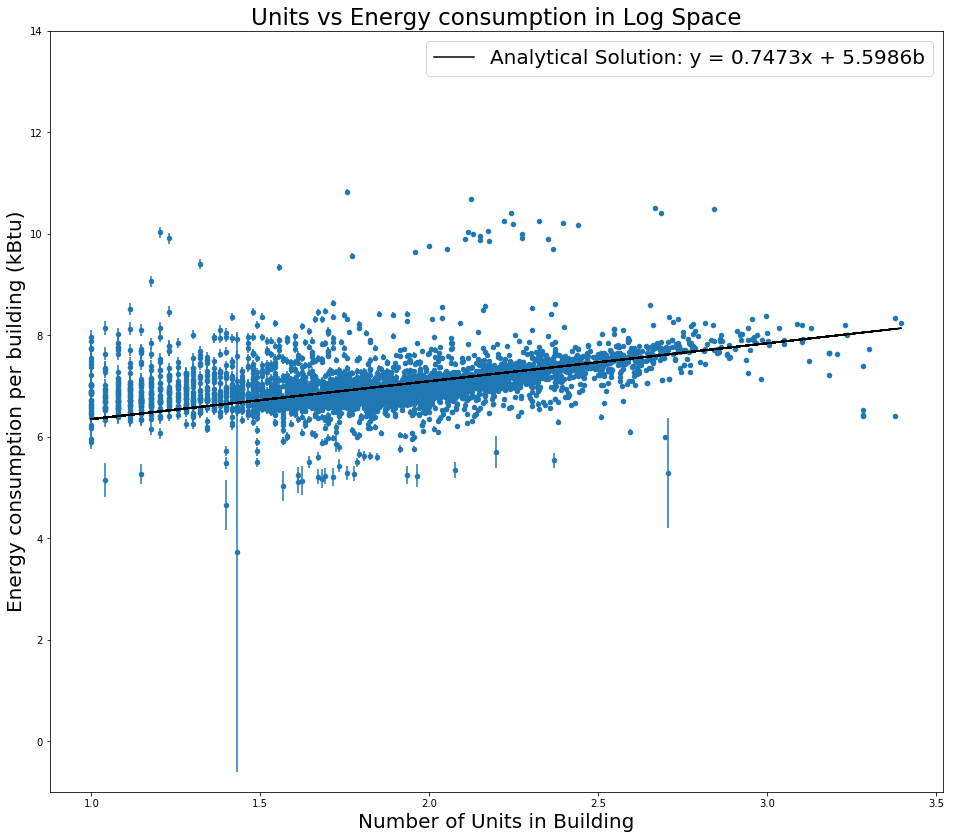

In [18]:
ax = bblnrgdataCut.plot(kind='scatter', y='nrglog', x='UnitsTotallog', yerr="errorlog",
                   marker='o', figsize=(16, 14), loglog=False)
ax.plot(bblnrgdataCut.UnitsTotallog, b_ls + m_ls * bblnrgdataCut.UnitsTotallog, 'k-')
yl = ax.set_xlabel("Number of Units in Building", fontsize=20)
xl = ax.set_ylabel("Energy consumption per building (kBtu)", fontsize=20)
ax.set_title("Units vs Energy consumption in Log Space",  fontsize=23)
ax.legend(["Analytical Solution: y = %.4fx + %.4fb"%(m_ls,b_ls),], fontsize=20 )
ax.set_ylim(-1,14)

## $Figure 1$: Line for to Units vs Energy consumption in log space: we observe that the fitting is not so good. 

--------

## 2. Likelihood model based on chi-square


### The below codes referred to the website:
http://dan.iel.fm/emcee/current/user/line/#maximum-likelihood-estimation

Maximum likelihood result:
    m = 0.468456861738 (truth: 0.74725384782)
    b = 6.1493357686 (truth: 5.59859129012)
    f = 0.0609074456136 (truth: 1)



(-1, 14)

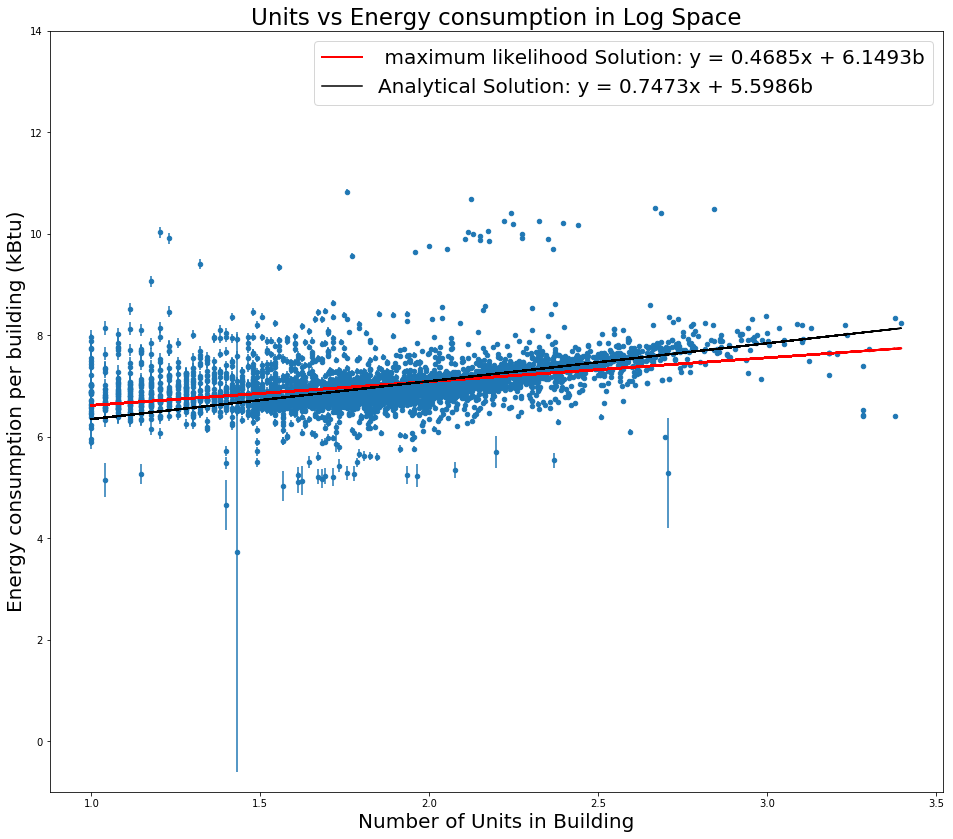

In [19]:
# Define the probability function as likelihood * prior.

def lnprior(theta):
    m, b, lnf = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b  
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))


x = bblnrgdataCut.UnitsTotallog
y = bblnrgdataCut.nrglog
yerr = bblnrgdataCut.errorlog
# Find the maximum likelihood value.
chi2 = lambda *args: -2 * lnlike(*args)
f_true = 1
result = op.minimize(chi2, [m_ls, b_ls, np.log(f_true)], args=(bblnrgdataCut.UnitsTotallog, \
                                                               bblnrgdataCut.nrglog, bblnrgdataCut.errorlog))

m_ml, b_ml, lnf_ml = result["x"]
print("""Maximum likelihood result:
    m = {0} (truth: {1})
    b = {2} (truth: {3})
    f = {4} (truth: {5})
""".format(m_ml, m_ls, b_ml, b_ls, np.exp(lnf_ml), f_true))

# Plot the maximum likelihood result.

ax = bblnrgdataCut.plot(kind='scatter', y='nrglog', x='UnitsTotallog', yerr="errorlog",
                   marker='o', figsize=(16, 14), loglog=False)
ax.plot(x, m_ml*x+b_ml, "r-", lw=2)
ax.plot(x, b_ls + m_ls * bblnrgdataCut.UnitsTotallog, 'k-')
yl = ax.set_xlabel("Number of Units in Building", fontsize=20)
xl = ax.set_ylabel("Energy consumption per building (kBtu)", fontsize=20)
ax.set_title("Units vs Energy consumption in Log Space",  fontsize=23)
ax.legend([" maximum likelihood Solution: y = %.4fx + %.4fb"%(m_ml,b_ml),\
           "Analytical Solution: y = %.4fx + %.4fb"%(m_ls,b_ls)], fontsize=20 )
ax.set_ylim(-1,14)


## $Figure2$:  In this Units vs Energy graph in log space, the maximum likelihood result is plotted as a solid red line—compared to the linear least squares (black line).

------

# Model 1.2 : Second degree polynomial model 

## Steps: define the model, set up the MCMC and run it

In [20]:
# Define the probability function as likelihood * prior.
# set a = 0

def lnprior(theta):
    a, m, b, lnf = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

def lnlike(theta, x, y, yerr):
    a, m, b, lnf = theta
    ## second degree
    model = a*(x**2) + m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)


# Set up the sampler.
ndim, nwalkers = 4, 100

### starting points from the max likelihood model
pos = [np.array([0, m_ml, b_ml, lnf_ml]) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

# Clear and run the production chain.
print("Running MCMC...")
sampler.run_mcmc(pos, 500)
print("Done.")

Running MCMC...
Done.


## Visualize the walker

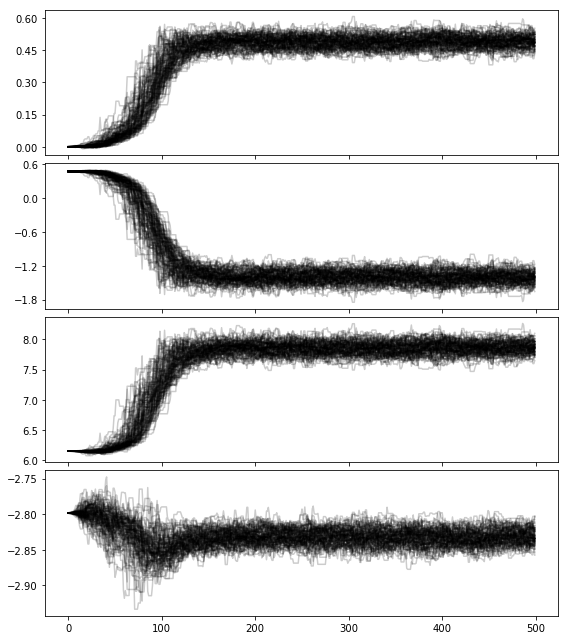

In [21]:
pl.clf()
fig, axes = pl.subplots(4, 1, sharex=True, figsize=(8, 9))

for i in range(4):
    
    axes[i].plot(sampler.chain[:, :, i].T, color="k", alpha=0.2)
    axes[i].yaxis.set_major_locator(MaxNLocator(5))


fig.tight_layout(h_pad=0.0)

## $Figure 3$:  Check the walkers for four variables and 
## find the burn-in point is around Step $150$

## Plot using Corner

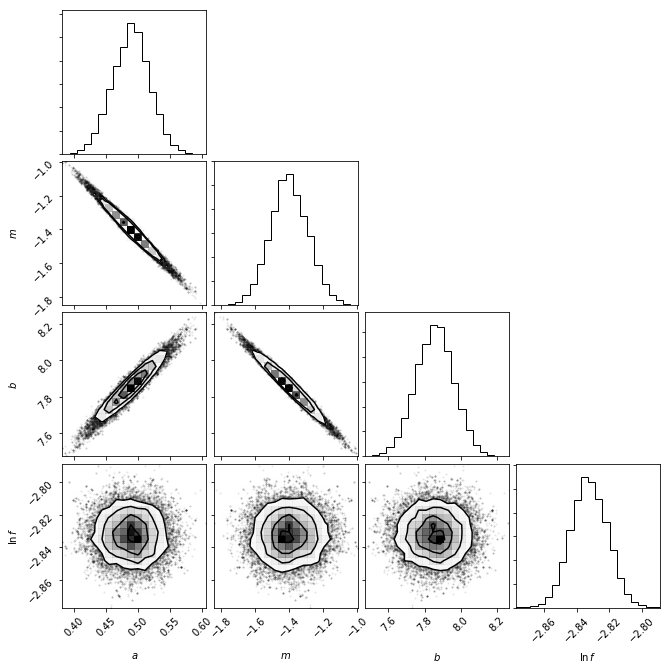

In [22]:
samples = sampler.chain[:, 150:, :].reshape((-1, ndim))

fig = corner.corner(samples, labels=["$a$", "$m$", "$b$", "$\ln\,f$"],
                      truths=[0, m_ls, b_ls, np.log(1)])

## Estimate  model parameters confidence intervals 

In [23]:
a_mcmc, m_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))

In [50]:
a_mcmc, m_mcmc, b_mcmc, f_mcmc

((0.48938865983016933, 0.028117071228962009, 0.0306130192453129),
 (-1.4027248287824143, 0.11588606717362304, 0.10881343184808689),
 (1.7125378698792715, 0.10534026997475854, 0.12272595218864057),
 (-3.1203120170072625, 0.046469628702253019, 0.017393660659544175))

## Use statsmodel for both the linear model and the second degree model

In [25]:
## use package statsmodel

bblnrgdataCut['logNrg']  = np.log10(bblnrgdataCut.nrg)
bblnrgdataCut['logUnits']  = np.log10(bblnrgdataCut.UnitsTotal)

X = np.linspace(bblnrgdataCut['logUnits'].min(), bblnrgdataCut['logUnits'].max(), 1000)

linearmodel = smf.ols(formula = 'logNrg ~ logUnits', data = bblnrgdataCut).fit()

curvemodel = smf.ols(formula = 'logNrg ~ logUnits + I(logUnits**2)', data = bblnrgdataCut).fit()
# linear line
linearmodel.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 logNrg   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     870.7
Date:                Tue, 25 Jul 2017   Prob (F-statistic):          2.04e-174
Time:                        02:04:30   Log-Likelihood:                -2594.3
No. Observations:                4297   AIC:                             5193.
Df Residuals:                    4295   BIC:                             5205.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.1138      0.032    191.642      0.000       6.051       6.176
logUnits       0.4864      0.016     29.508      0.000       0.454       0.519
==============================================================================
Omnibus:                     2234.650   Durbin-Watson:                   1.680
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            43640.542
Skew:                           2.035   Prob(JB):                         0.00
Kurtosis:                      18.073   Cond. No.                         11.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
# poly line
curvemodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 logNrg   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     581.3
Date:                Tue, 25 Jul 2017   Prob (F-statistic):          3.80e-224
Time:                        02:04:34   Log-Likelihood:                -2476.1
No. Observations:                4297   AIC:                             4958.
Df Residuals:                    4294   BIC:                             4977.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            7.6454      0.103     74.179      0.000       7.443       7.847
logUnits            -1.1706      0.108    -10.886      0.000      -1.381      -0.960
I(logUnits ** 2)     0.4278      0.027     15.584      0.000       0.374       0.482
==============================================================================
Omnibus:                     2296.352   Durbin-Watson:                   1.705
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            55733.414
Skew:                           2.041   Prob(JB):                         0.00
Kurtosis:                      20.165   Cond. No.                         105.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## $Comment$: From the OLS summary, we can see the linear model has R^2 score 0.169, and the fitted second degree line of Units vs Energy has R^2 of 0.213. Both of the R^2 is low, the second degree line is slightly better than the linear model, which is obvious.

------

In [27]:
## from statsmodel, use the params from second degree model
Intercept_poly,logUnits_poly, logUnits2_poly = curvemodel.params

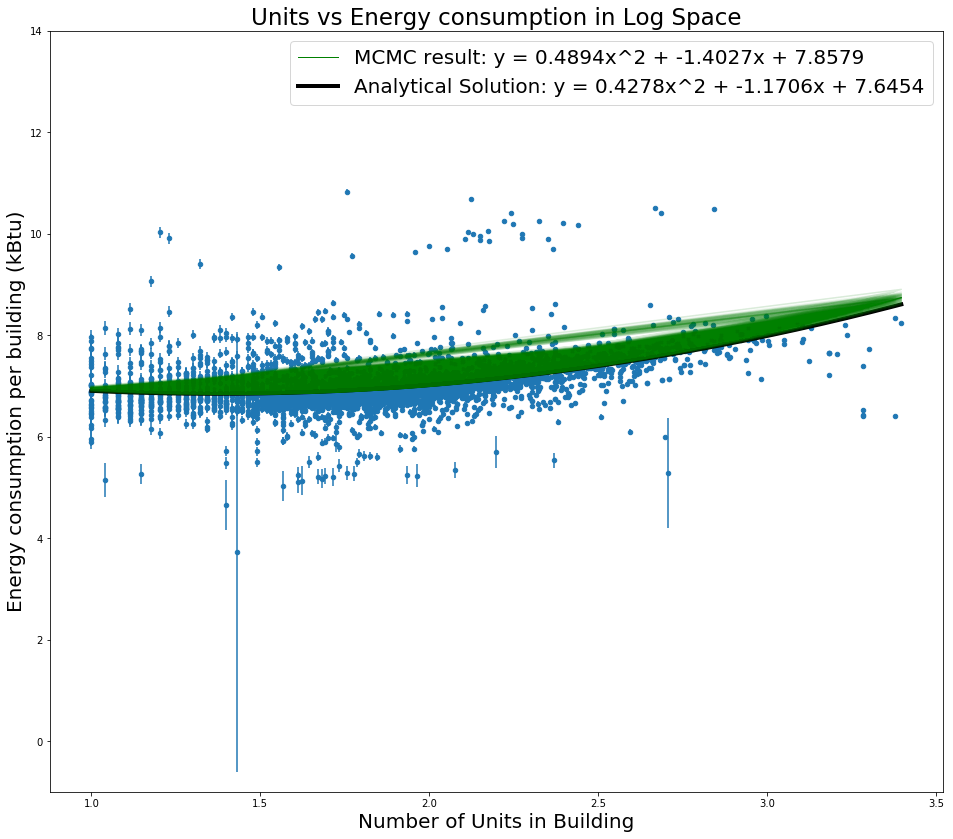

In [30]:
ax = bblnrgdataCut.plot(kind='scatter', y='nrglog', x='UnitsTotallog', yerr="errorlog",
                   marker='o', figsize=(16, 14), loglog=False)

ax.plot(X, a_mcmc[0]*X**2+ m_mcmc[0]*X + b_mcmc[0], "g-", lw=1, label="MCMC result")

ax.plot(X, curvemodel.predict(exog = dict(logUnits = X)), 'k', lw=4)


ax.set_ylim(-1,14)
for a, m, b, f in samples[np.random.randint(len(samples), size=100)]:
    ax.plot(x, a*x**2 + m*x+b, color="g", alpha=0.05)
    
ax.legend(["MCMC result: y = %.4fx^2 + %.4fx + %.4f"%(a_mcmc[0],m_mcmc[0],b_mcmc[0]),
          "Analytical Solution: y = %.4fx^2 + %.4fx + %.4f"%(logUnits2_poly,logUnits_poly,Intercept_poly)], 
          fontsize=20)


ax.set_xlabel("Number of Units in Building", fontsize=20)
ax.set_ylabel("Energy consumption per building (kBtu)", fontsize=20)
ax.set_title("Units vs Energy consumption in Log Space",  fontsize=23)

## $Comment$: The black solid line is the fitted polynomial line.  The green model with the MCMC best fit parameters identified as the median of the joint posterior distributions, is indicated. The green shades represent the intervals (16% and 84% percentile) for each chain are plotted.
-----
---------____

# Model 2: multivariate linear regression
chose 5 variables and try a linear regression on the 5 variables

In [31]:
bblnrgdataCut['logNumFloors'] = np.log10(bblnrgdataCut.NumFloors)
# get the sum of residential and retail area
bblnrgdataCut['logArea'] = np.log10(bblnrgdataCut.ResArea + bblnrgdataCut.RetailArea + bblnrgdataCut.BldgArea)
# get the per building area
bblnrgdataCut['logPerBldgArea'] = np.log10(bblnrgdataCut.BldgArea/bblnrgdataCut.NumBldgs)

bblnrgdataCut['logPerFloorArea'] = \
np.log10(bblnrgdataCut["Reported Property Floor Area (Building(s)) (ft²)"]/bblnrgdataCut.NumFloors)

bblnrgdataCut['logBldgArea'] = np.log10(bblnrgdataCut.BldgArea)

/Users/lexu/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/pandas/core/common.py:149: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if a.name == b.name:


## Preprocessing:  whiten the data

In [32]:
bblnrgdataCut[["logNrg","logUnits",'logNumFloors','logPerBldgArea',"logPerFloorArea","logBldgArea"]]= \
whiten(bblnrgdataCut[["logNrg","logUnits",'logNumFloors','logPerBldgArea',"logPerFloorArea","logBldgArea"]])

features = whiten(bblnrgdataCut[["logUnits",'logNumFloors','logPerBldgArea',"logPerFloorArea","logBldgArea"]])

bblnrgdataCut["logNrg"] = whiten(bblnrgdataCut['logNrg'])

/Users/lexu/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/pandas/indexes/base.py:1100: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  return self._engine.is_unique


In [34]:
multi_model = smf.ols(formula = 'logNrg ~ logUnits + logNumFloors + logPerFloorArea + logPerBldgArea + logBldgArea', \
                      data = bblnrgdataCut).fit()

In [35]:
multi_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 logNrg   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     1021.
Date:                Tue, 25 Jul 2017   Prob (F-statistic):               0.00
Time:                        02:06:46   Log-Likelihood:                -4413.6
No. Observations:                4297   AIC:                             8839.
Df Residuals:                    4291   BIC:                             8877.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.5775      0.187     19.141      0.000       3.211       3.944
logUnits            0.0495      0.012      3.987      0.000       0.025       0.074
logNumFloors        0.4342      0.023     19.149      0.000       0.390       0.479
logPerFloorArea     0.4288      0.021     20.891      0.000       0.389       0.469
logPerBldgArea      0.0441      0.025      1.747      0.081      -0.005       0.094
logBldgArea         0.0923      0.035      2.618      0.009       0.023       0.161
==============================================================================
Omnibus:                     3401.423   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           268902.705
Skew:                           3.195   Prob(JB):                         0.00
Kurtosis:                      41.224   Cond. No.                         482.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## For 

In [36]:
print('R2 = %f'%multi_model.rsquared)
pd.DataFrame({'Regression':multi_model.params})

R2 = 0.543238


,Regression
Intercept,3.577460
logUnits,0.049464
logNumFloors,0.434177
logPerFloorArea,0.428792
logPerBldgArea,0.044113
logBldgArea,0.092253


## $Comment$: From the model summary, the multivariate linear regression has R^ of .54, which is okay, no so good. 

##  Set up the MCMC, run the simulation

In [40]:
# Define the probability function as likelihood * prior.
def lnprior(theta):
    m1,m2,m3,m4,m5,b,lnf = theta
    if -5.0 < m1 < 0.5 and 0.0 < b < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf


def lnlike(theta, x, y, yerr):
    m1,m2,m3,m4,m5,b,lnf = theta
    model = m1*x[0]+ m2*x[1] + m3*x[2] + m4*x[3] + m5*x[4] + b
    
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))


def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)



m = np.array(multi_model.params[1:])
b = multi_model.params[0]

x = np.array(features.T)
y = bblnrgdataCut.nrglog
yerr = bblnrgdataCut.errorlog

# Set up the sampler.
ndim, nwalkers = 7, 100
#pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

pos = [np.array([m[0],m[1],m[2],m[3],m[4],b, 0]) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

# Clear and run the production chain.
print("Running MCMC...")
sampler.run_mcmc(pos, 500)
print("Done.")




Running MCMC...
Done.


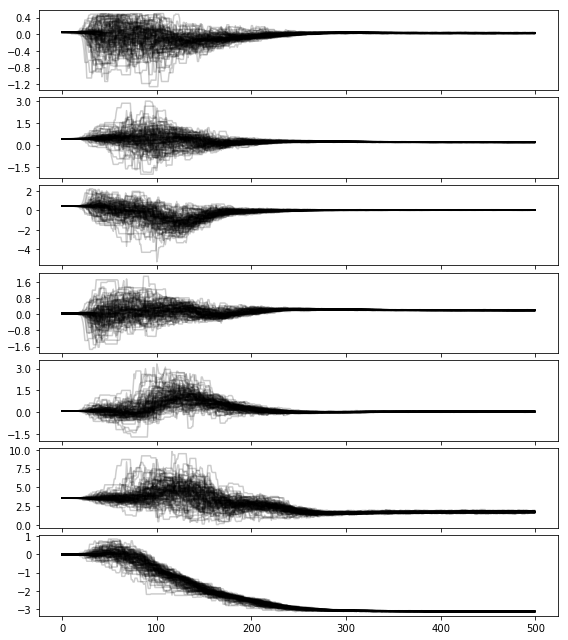

In [41]:
pl.clf()
fig, axes = pl.subplots(7, 1, sharex=True, figsize=(8, 9))

for i in range(7):
    
    axes[i].plot(sampler.chain[:, :, i].T, color="k", alpha=0.2)
    axes[i].yaxis.set_major_locator(MaxNLocator(5))


fig.tight_layout(h_pad=0.0)

## The burn in point is 250

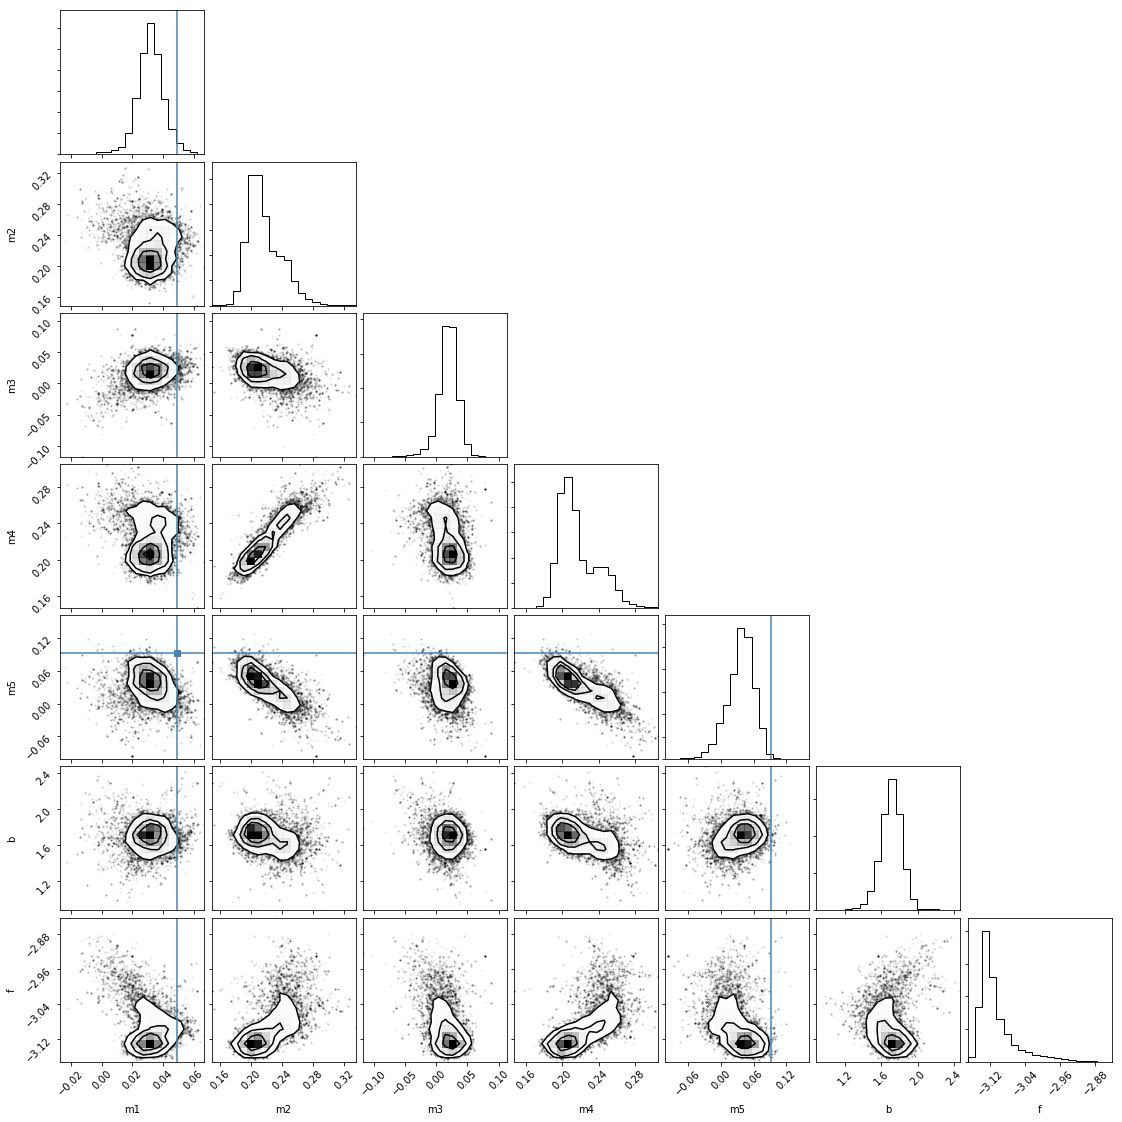

In [46]:
samples = sampler.chain[:, 250:, :].reshape((-1, ndim))

fig = corner.corner(samples, labels=["m1","m2","m3","m4","m5","b","f"],
                      truths=[m[0],m[1],m[2],m[3],m[4],b,0])


In [47]:
m1_mcmc, m2_mcmc, m3_mcmc, m4_mcmc, m5_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))
mcmcRes = np.concatenate([m1_mcmc, m2_mcmc, m3_mcmc, m4_mcmc, m5_mcmc, b_mcmc, f_mcmc])

In [48]:
mcmcRes = np.concatenate([m1_mcmc, m2_mcmc, m3_mcmc, m4_mcmc, m5_mcmc, b_mcmc, f_mcmc])
print ("""MCMC result:
          m1\t{0:.4f} ({1:.4f}, {2:.4f})
          m2\t{3:.4f} ({4:.4f}, {5:.4f})
          m3\t{6:.4f} ({7:.4f}, {8:.4f})
          m4\t{9:.4f} ({10:.4f}, {11:.4f})
          m5\t{12:.4f} ({13:.4f}, {14:.4f})
          b\t{15:.4f} ({16:.4f}, {17:.4f})
          """.format(*mcmcRes))

MCMC result:
          m1	0.0318 (0.0079, 0.0078)
          m2	0.2119 (0.0292, 0.0150)
          m3	0.0198 (0.0130, 0.0142)
          m4	0.2110 (0.0316, 0.0129)
          m5	0.0384 (0.0206, 0.0279)
          b	1.7125 (0.1053, 0.1227)
          
